note for wiktor and will: you guys will need to create an enviroment with python 3.8-3.11 for this. Latest 3.12 doesn't support tensorflow.
you also may need to install dependencies manually as pip can mess up tensorflow.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [16]:
feature_prediction = 'Open'
ticker = 'MSFT'

In [17]:
df = pd.read_csv('../Prepared Data/MSFT/MSFT_stock_data_2020-01-01_to_2023-12-31.csv')

close_prices = df[feature_prediction].values.reshape(-1, 1)

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(close_prices)

In [19]:
split_point = int(len(data_normalized) * 0.8)
train, test = data_normalized[:split_point, :], data_normalized[split_point:, :]

In [20]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3  # Number of days the model will look back
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [21]:
model = Sequential([
    LSTM(50, input_shape=(1, look_back)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
800/800 - 1s - loss: 0.0097 - 1s/epoch - 2ms/step
Epoch 2/100
800/800 - 1s - loss: 6.4644e-04 - 640ms/epoch - 800us/step
Epoch 3/100
800/800 - 1s - loss: 6.2337e-04 - 691ms/epoch - 864us/step
Epoch 4/100
800/800 - 1s - loss: 6.2374e-04 - 640ms/epoch - 800us/step
Epoch 5/100
800/800 - 1s - loss: 5.7250e-04 - 642ms/epoch - 802us/step
Epoch 6/100
800/800 - 1s - loss: 5.9197e-04 - 673ms/epoch - 841us/step
Epoch 7/100
800/800 - 1s - loss: 5.1559e-04 - 660ms/epoch - 825us/step
Epoch 8/100
800/800 - 1s - loss: 5.2514e-04 - 609ms/epoch - 761us/step
Epoch 9/100
800/800 - 1s - loss: 5.2751e-04 - 675ms/epoch - 844us/step
Epoch 10/100
800/800 - 1s - loss: 5.0080e-04 - 659ms/epoch - 824us/step
Epoch 11/100
800/800 - 1s - loss: 4.7479e-04 - 603ms/epoch - 754us/step
Epoch 12/100
800/800 - 1s - loss: 4.9927e-04 - 603ms/epoch - 753us/step
Epoch 13/100
800/800 - 1s - loss: 4.7323e-04 - 607ms/epoch - 759us/step
Epoch 14/100
800/800 - 1s - loss: 5.0147e-04 - 597ms/epoch - 746us/step
Epoch 15/1

In [22]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform([Y_test])

7/7 [==============================] - 0s 936us/step


In [23]:
train_score = np.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

Train Score: 4.77 RMSE
Test Score: 6.20 RMSE


<module 'matplotlib.pyplot' from 'C:\\Users\\tpasl\\miniconda3\\envs\\tensorflow\\lib\\site-packages\\matplotlib\\pyplot.py'>

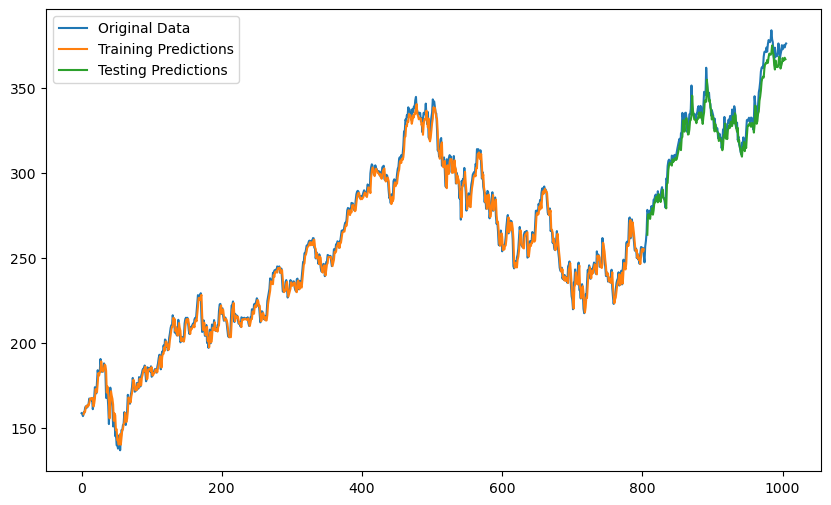

In [24]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data_normalized)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_normalized)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_normalized)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(data_normalized), label='Original Data')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Testing Predictions')
plt.legend()
plt

In [26]:
model.save(f'../Models (Unfinished)/LSTM_{feature_prediction}_{ticker}')

INFO:tensorflow:Assets written to: ../Models (Unfinished)/LSTM_Open_MSFT\assets


INFO:tensorflow:Assets written to: ../Models (Unfinished)/LSTM_Open_MSFT\assets
